# Visualizing ConvNets

In this notebook,

* We will look at the learned patterns of ConvNets and examine how they essentially learn.
* Then, which part of the image they are looking mostly to make a prediction.

### Required Modules:

In [ ]:
from keras import layers, models
from keras.applications import VGG16
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from matplotlib import pyplot as plt
import numpy as np

### Let's see how VGG16 model learns

* Firstly load our saved model. The first layer of our model contains all convolutional parts of the VGG16 model. That means it has many convolutional layers inside it. 

In [ ]:
model = load_model('cats_and_dogs_small.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


* Choosing and loading an image to extract its patters.

In [ ]:
img_path = '/content/drive/My Drive/Colab Notebooks/Kaggle/cat_and_dogs_small/test/cats/cat.1700.jpg'

In [ ]:
img = image.load_img(img_path, target_size=(150,150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255

print(img_tensor.shape)

(1, 150, 150, 3)


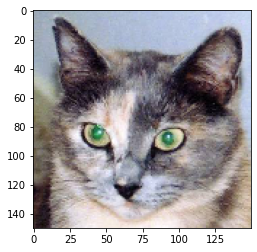

In [ ]:
plt.imshow(img_tensor[0])
plt.show()

`model.layers` gives us the list of layers of our model. To achieve the input of our model, we should select the VGG16 model using; `model.layers[0]` and take the 0th index of it `get_input_at(0)`.

In [ ]:
model.layers[0].get_input_at(0)

<tf.Tensor 'vgg16_input:0' shape=(None, 150, 150, 3) dtype=float32>

### Summary of ConvNets of VGG16.

In [ ]:
model.layers[0].summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

To obtain patterns, we should look at the output of each convolutional layer.

`activation_model` we created gives us the outputs of 8 layers since we specified a list of these outputs during the creation of the model.

In [ ]:
layer_outputs = [layer.output for layer in model.layers[0].layers[1:9]]
activation_model = models.Model(inputs=model.layers[0].input, outputs=layer_outputs)

# to predinct the image we chose above
activations = activation_model.predict(img_tensor)

# returns the output of 1st layer (after input layer)
first_layer_activation = activations[0]

print(first_layer_activation.shape)

(1, 150, 150, 64)


As shown in the images below, the convolutional layers return images with specific patterns such as the outlines of the cat, and eyes of it.

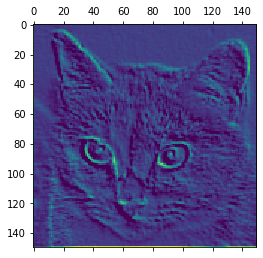

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

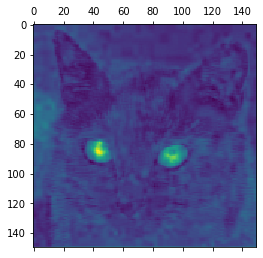

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 12], cmap='viridis')

### Plotting each activation layer

* It seems each of them focuses on different things on image

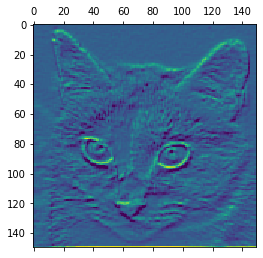

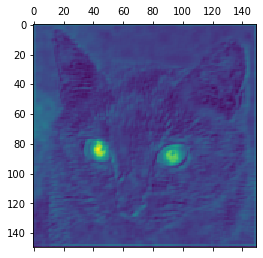

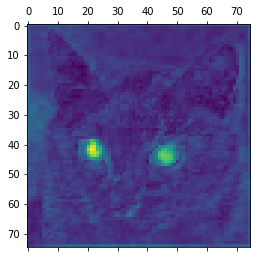

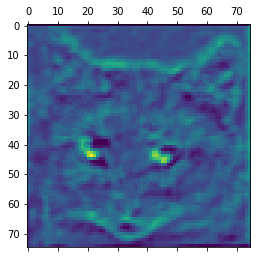

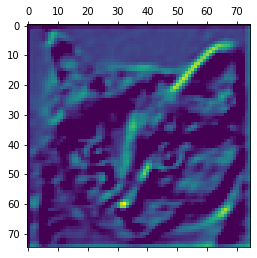

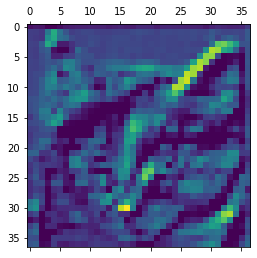

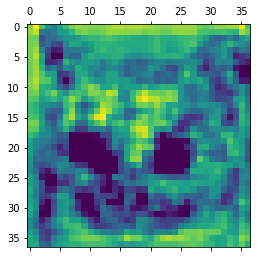

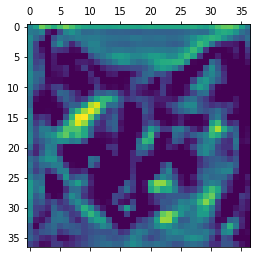

In [ ]:
for layer in range(8):
    layer_activation = activations[layer]
    plt.matshow(layer_activation[0, :, :, 3], cmap='viridis')

### Plotting All Filters of Each Layer

In [ ]:
# collecting the names of each activation layer
layer_names = []
for layer in model.layers[0].layers[1:9]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')

            # Place it in display_grid matrix
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

Output hidden; open in https://colab.research.google.com to view.

We can easily plot the whole filters in the model in order to get better intuition about how they learn. As an example, in `block2_conv2`, filters are mostly focusing on diagonal, horizontal, or vertical lines.

### Visualizing Heatmap

In [ ]:
K.clear_session()

model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 14s 0us/step


* Note that we are including the densely-connected classifier on top; previously, we were discarding it.

In [ ]:
from keras.applications.vgg16 import preprocess_input, decode_predictions

# The local path to our target image
img_path = '/content/drive/My Drive/Colab Notebooks/Keras Book/ch 5 Computer Vision/creative_commons_elephant.jpg'

# loading image in size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

In [ ]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02504458', 'African_elephant', 0.9094213), ('n01871265', 'tusker', 0.08618258), ('n02504013', 'Indian_elephant', 0.004354576)]


The model has predicted the African elephant with a 90% probability. Let's see how the model decided that.

In [ ]:
np.argmax(preds[0])

386

### Extracting Heatmap

In [ ]:
# This is the "african elephant" entry in the prediction vector
african_elephant_output = model.output[:, 386]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

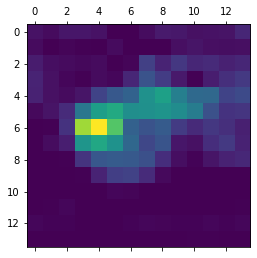

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

### Applying Heatmap to the Original Image

In [ ]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

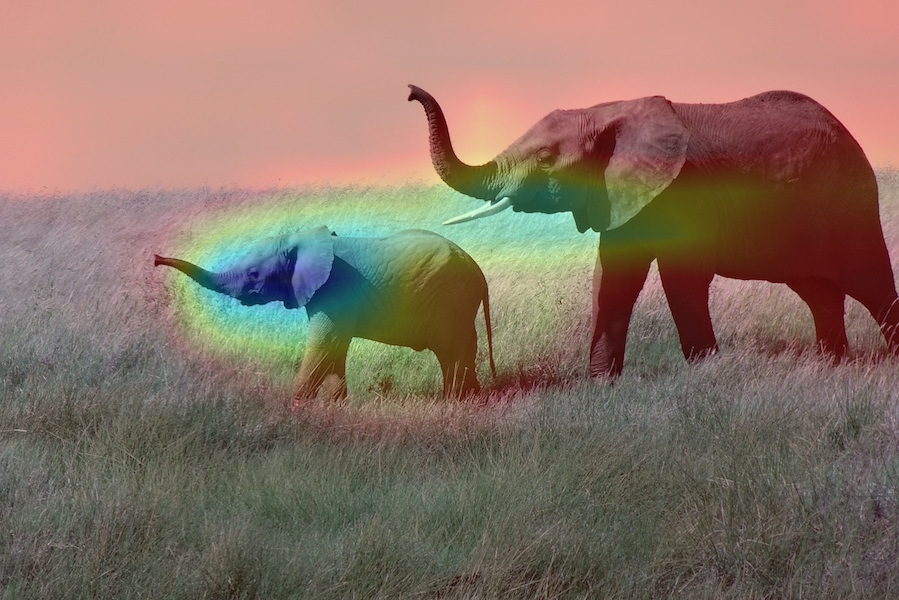

In [ ]:
image.array_to_img(superimposed_img)

Sources:

* https://keras.io/examples/vision/grad_cam/
* Book: Deep Learning with Python by Francois Chollet

Also, look at [How convolutional neural networks see the world](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html) by Francois Chollet if you are interested